https://medium.com/p/8b7685aa8cf

https://github.com/mikekeith52/scalecast-examples/blob/main/lstm/lstm.ipynb

Scalecast documents:  

* https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html


In [1]:
!pip install scalecast --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 878.7/878.7 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.0 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.18.7-py3-none-any.whl size=111648 sha256=2e81d55bb9d98269b24e8417deeb3ac0276858f2548ea3c85893b5972743f436
  Stored in directory: /root/.cache/pip/wheels/e7/c6/16/3a913cd79a26d7fad4487969613734b95555cf4351233eb255
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=

In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 18.8 MB/s eta 0:00:00


In [4]:
#######################
### Model framework ###
#######################

def cap_floor(train_dset, test_dset, name, initial, period, horizon):

    train_dset['cap'] = max(int(max(train_dset.y) * 1.1),int(max(test_dset.y) * 1.1))
    train_dset['floor'] = 0
    test_dset['cap'] = train_dset['cap']
    test_dset['floor'] = 0
    #return train_df, test_dset

    ### Baseline model ###

    m = Prophet()
    m.fit(train_dset)

    ### Strict model ###

    m_strict = Prophet(changepoint_prior_scale=0.01,
                       weekly_seasonality=False,
                       daily_seasonality=False,
                       yearly_seasonality=True,
                       seasonality_mode = 'additive')
    m_strict.fit(train_dset)

    ### Flexible model ###

    m_flex = Prophet(changepoint_prior_scale=0.5)
    m_flex.fit(train_dset)

    ### Holiday-Regressors-Seasonality ###

    m_hrs = Prophet(weekly_seasonality=False,
                    daily_seasonality=False,
                    yearly_seasonality=True,
                    seasonality_mode = 'additive',
                    changepoint_prior_scale = 0.1,
                    seasonality_prior_scale = 10.0)
    m_hrs.add_regressor('Year')
    m_hrs.add_regressor('Month')
    m_hrs.add_regressor('Is_quarter_start')
    m_hrs.add_regressor('Is_year_start')
    m_hrs.fit(train_dset)

    ### Holiday-Regressors-Seasonality ###

    m_comp = Prophet(
                    seasonality_mode = 'additive',      # seasonality_mode = 'multiplicative',
                    changepoint_prior_scale = 0.1,
                    seasonality_prior_scale = 10.0,
                    holidays_prior_scale = 20.0,
                    weekly_seasonality = False,
                    daily_seasonality = False,
                    yearly_seasonality = False,
                    ).add_seasonality(
                        name = 'monthly',
                        period = 30.5,
                        fourier_order = 55
                    ).add_seasonality(
                        name = 'yearly',
                        period = 365.25,
                        fourier_order = 20
                    ).add_seasonality(
                        name = 'quarterly',
                        period = 365.25 / 4,
                        fourier_order = 5,
                        prior_scale = 15
                    ).add_seasonality(
                        name = 'bi-monthly',
                        period = 365.25 / 6,
                        fourier_order = 5,
                        prior_scale = 15
                    )

    m_comp.add_regressor('Year')
    m_comp.add_regressor('Month')
    m_comp.add_regressor('Is_quarter_start')
    m_comp.add_regressor('Is_year_start')
    m_comp.fit(train_dset)


    df_all = pd.DataFrame()

    y_train = train_dset.y
    y_test = test_dset.y
    y_test.index = y_test.index + max(y_train.index)
    print(y_train.shape[0], y_test.shape[0])

    df_cv, df_p, forecast, prop_test = mod_diag(m, 'Baseline model', test_dset, y_train, y_test, name, initial, period, horizon)
    df_p['Model'] = 'Baseline'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_cv, df_p, forecast, prop_test = mod_diag(m_strict, 'Strict model', test_dset, y_train, y_test, name, initial, period, horizon)
    df_p['Model'] = 'Strict'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_cv, df_p, forecast, prop_test = mod_diag(m_flex, 'Flexible model', test_dset, y_train, y_test, name, initial, period, horizon)
    df_p['Model'] = 'Flexible'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_cv, df_p, forecast, prop_test = mod_diag(m_hrs, 'Holiday-Regressor-Seasonal model', test_dset, y_train, y_test, name, initial, period, horizon)
    df_p['Model'] = 'HRS'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_cv, df_p, forecast, prop_test = mod_diag(m_comp, 'Constructed model', test_dset, y_train, y_test, name, initial, period, horizon)
    df_p['Model'] = 'Constructed'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_all['days'] = df_all['horizon'].astype('timedelta64[D]')
    df_all['days'] = df_all['days'].astype(int)

    f = plt.figure(figsize=(10, 7))
    ax = sns.lineplot(x="days", y="smape", hue="Model", markers=True, data=df_all)
    ax.set(xlabel='Date', ylabel='SMAPE')
    plt.show();

    return df_all

In [5]:
def mod_diag(model, mod_name, test_df, y_train, y_test, name, initial, period, horizon):
    f = plt.figure(figsize=(10, 7))
    plot_series(y_train, y_test, labels=["y_train", "y_test"], title = f'{name} Train-test plot');

    df_cv, df_p, forecast, prop_test = cv_exam(model, test_df, y_test, initial, period, horizon)
    fig = model.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), model, forecast)
    mape_ph = mean_absolute_percentage_error(prop_test['y'], prop_test['yhat'], symmetric=True)
    mse_ph = mean_squared_error(prop_test['y'], prop_test['yhat'], squared=False)
    print(f"The Smape loss value for {name} and {mod_name} model is {mape_ph:.6f}")
    print(f"The RMSE loss value for {name} and {mod_name} model is {mse_ph:.6f}")

    plot_series(prop_test['yhat'], y_test, labels=["y_pred","y_test"], title = f'{name} {mod_name} Test predict-actuals plot')
    plt.show();

    fig = model.plot_components(forecast)
    f = plt.figure(figsize=(10, 7))
    ax = sns.lineplot(x="ds", y="residual", markers=True, data=df_cv)
    ax.set(xlabel='Dates', ylabel='Residuals')
    plt.show();
    return df_cv, df_p, forecast, prop_test

In [6]:
def cv_exam(model, test_df, y_test, initial, period, horizon):

    forecast = model.predict(test_df)
    df_cv = cross_validation(model, initial = initial, period = period, horizon = horizon)
    df_p = performance_metrics(df_cv)
    df_cv['residual'] = df_cv['y'] - df_cv['yhat']
    prop_test = pd.merge(test_df,forecast[['yhat','ds']],on=['ds'],how='inner')
    prop_test.index = y_test.index

    return df_cv, df_p, forecast, prop_test

In [7]:
def perf_vals(dset, meas = 'smape'):
    rmse_add = dset.groupby(['Model'])[meas].mean()
    rmse_add = pd.DataFrame(rmse_add)
    a = rmse_add.sort_values(by = [meas])

    rmse_add = rmse_add.reset_index()
    model = rmse_add[rmse_add[meas] == min(rmse_add[meas])]
    print(f"The best model is the {model['Model'].values[0]} model")

    return a

def res_data(dset,meas,name,res_dset):
    try:
        baby = perf_vals(dset,meas)
        baby[str(name + ' Model')] = baby.index
        baby.rename(columns = {meas : str(name) + ' ' + str(meas.capitalize())}, inplace = True)
        baby = baby.reset_index(drop=True)
        res_dset = pd.concat([res_dset,baby], axis = 1)
        res_dset = res_dset.reset_index(drop=True)
        return res_dset
    except:
        print('No ' + name + ' data')


In [8]:
def hyper(train_dset, test_dset, initial, period, horizon):

    train_dset['cap'] = max(int(max(train_dset.y) * 1.1),int(max(test_dset.y) * 1.1))
    train_dset['floor'] = 0
    test_dset['cap'] = train_dset['cap']
    test_dset['floor'] = 0

    ### Create a list to store MAPE values for each combination ###
    mapes = []

    ### Use cross validation to evaluate all parameters ###

    for params in all_params:
        ### Fit a model using one parameter combination ###
        m = Prophet(**params)
        m.add_regressor('Year')
        m.add_regressor('Month')
        m.add_regressor('Is_quarter_start')
        m.add_regressor('Is_year_start')
        m.fit(train_dset)

        ### Cross-validation ###
        df_cv = cross_validation(m, initial = initial, period = period, horizon = horizon, parallel="processes")

        ### Model performance ###
        df_p = performance_metrics(df_cv, rolling_window=1)

        ### Save model performance metrics ###
        mapes.append(df_p['smape'].values[0])

    ### Tuning results
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mape'] = mapes
    # Find the best parameters
    best_params = all_params[np.argmin(mapes)]
    print(best_params)
    return best_params


In [9]:
def all_mod(train_dset, test_dset, params, df_comp, initial, period, horizon, name):

    train_dset['cap'] = max(int(max(train_dset.y) * 1.1),int(max(test_dset.y) * 1.1))
    train_dset['floor'] = 0
    test_dset['cap'] = train_dset['cap']
    test_dset['floor'] = 0

    y_train = train_dset.y
    y_test = test_dset.y
    y_test.index = y_test.index + max(y_train.index)
    print(y_train.shape[0], y_test.shape[0])

    ### Fit the model using the best parameters ###

    auto_model = Prophet(changepoint_prior_scale = params['changepoint_prior_scale'],
                         seasonality_prior_scale = params['seasonality_prior_scale'],
                         seasonality_mode = params['seasonality_mode'],
                         growth = params['growth'])

    auto_model.add_regressor('Year')
    auto_model.add_regressor('Month')
    auto_model.add_regressor('Is_quarter_start')
    auto_model.add_regressor('Is_year_start')

    ### Fit the model on the training dataset ###

    auto_model.fit(train_dset)

    ### Cross validation ###
    auto_model_cv, auto_model_p, forecast_auto, prop_test_auto = cv_exam(auto_model, test_dset, y_test, initial, period, horizon)

    fig = auto_model.plot(forecast_auto)
    a = add_changepoints_to_plot(fig.gca(), auto_model, forecast_auto)

    mape_ph_auto = mean_absolute_percentage_error(prop_test_auto['y'], prop_test_auto['yhat'], symmetric=True)

    print(f"The Smape loss value for {name} is {mape_ph_auto:.6f}")
    # 0.111345
    print(f"The RMSE value is {mean_squared_error(prop_test_auto['y'], prop_test_auto['yhat'], squared=False)}")
    # 1186.9104787999713
    plot_series(prop_test_auto['yhat'], y_test, labels=["y_pred", "y_test"], title = f'{name} Hyperparameter Train-test plot');

    f = plt.figure(figsize=(10, 7))
    ax = sns.lineplot(x="ds", y="residual", markers=True, data=auto_model_cv)
    ax.set(xlabel='Dates', ylabel='Residuals')
    plt.show()

    ### Model performance metrics ###
    auto_model_pm = performance_metrics(auto_model_cv, rolling_window=1)
    print(auto_model_pm)

    auto_model_p['Model'] = 'Hyperparameter'

    df_comp = pd.concat([df_comp,auto_model_p], axis = 0).reset_index(drop=True)
    df_comp['days'] = df_comp['horizon'].astype('timedelta64[D]')
    df_comp['days'] = df_comp['days'].astype(int)

    f = plt.figure(figsize=(19, 15))
    ax = sns.lineplot(x="days", y="smape", hue="Model", markers=True, data=df_comp)
    ax.set(xlabel='Date', ylabel='SMAPE')
    plt.show();
    return df_comp

In [10]:
####################################################
### Convert date to more informative information ###
####################################################

def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [11]:
################################
### Process time series data ###
################################

def train_dset(dset):
    time_data_ph = dset.drop(['MonthElapsed','MonthWeek','MonthDayofweek','MonthIs_month_end',
                              'MonthIs_month_start','MonthIs_quarter_end','MonthIs_year_end',
                              'MonthDayofyear','MonthDay'],axis = 1)
    time_data_ph.arrival_date = time_data_ph.Month.astype('datetime64[ns]')
    time_data_ph.rename(columns = {'#Passengers':'y', 'Month':'ds'}, inplace = True)

    time_data_ph = time_data_ph.sort_values('ds')
    time_data_ph['y'] = time_data_ph['y'].astype(int)
    time_data_ph['ds'] = pd.to_datetime(time_data_ph['ds'], format='%Y-%m-%d')
    time_data_ph = time_data_ph.reset_index(drop=True)
    time_data_ph.columns = ['ds', 'y', 'Year', 'Month', 'Is_quarter_start','Is_year_start']

    for name in ['Is_quarter_start','Is_year_start']:
        time_data_ph[name] = time_data_ph[name].astype(int)
    return time_data_ph

In [12]:
def forecst(a, name):
    a = a[(a.DATE <= df_test.ds.max()) & (a.DATE >= df_test.ds.min())]
    mape_ph = mean_absolute_percentage_error(a['Actuals'], a['FittedVals'], symmetric=True)
    mse_ph = mean_squared_error(a['Actuals'], a['FittedVals'], squared=False)
    print(f"The Smape loss value for {name} model is {mape_ph:.6f}")
    print(f"The RMSE loss value for {name} model is {mse_ph:.6f}")

    plot_series(a['FittedVals'], a['Actuals'], labels=["y_pred","y_test"], title = f'{name} Test predict-actuals plot')
    plt.show();

    f = plt.figure(figsize=(10, 7))
    ax = sns.lineplot(x="DATE", y="Residuals", markers=True, data=a)
    ax.set(xlabel='Dates', ylabel='Residuals')
    plt.show();

In [13]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [14]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
import itertools

from scalecast.Forecaster import Forecaster

from tensorflow.keras.callbacks import EarlyStopping

from scalecast.SeriesTransformer import SeriesTransformer
from scalecast.auxmodels import auto_arima

from sklearn.preprocessing import MinMaxScaler

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sktime.utils.plotting import plot_series

In [15]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Change directory
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/LSTM")
# Print out the current directory
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/LSTM


In [16]:
df = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])
df.Month = pd.to_datetime(df.Month).dt.date
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [18]:
add_datepart(df, 'Month', drop = False)
df = train_dset(df)
df.head()

<ipython-input-10-ab80e96be6d1>:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
<ipython-input-11-8262227a148e>:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  time_data_ph.arrival_date = time_data_ph.Month.astype('datetime64[ns]')


,ds,y,Year,Month,Is_quarter_start,Is_year_start
0,1949-01-01,112,1949,1,1,1
1,1949-02-01,118,1949,2,0,0
2,1949-03-01,132,1949,3,0,0
3,1949-04-01,129,1949,4,1,0
4,1949-05-01,121,1949,5,0,0


### Test-Train split

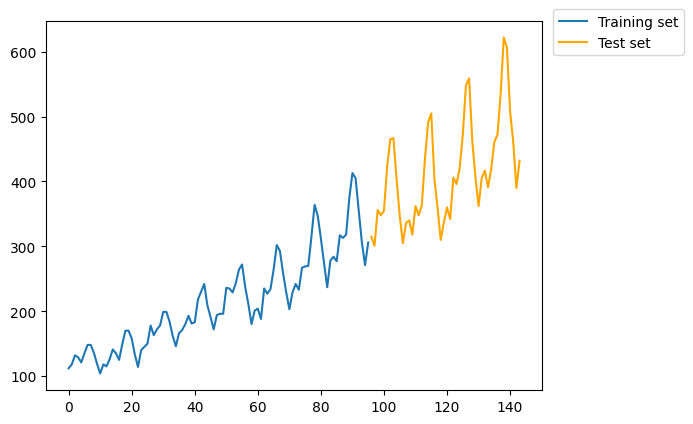

In [19]:
test_size = int(df.shape[0]/3)

df_train = df[:-test_size]
df_test = df[-test_size:]

plt.plot(df_train.y, label='Training set')
plt.plot(df_test.y, label='Test set', color='orange')
plt.legend(bbox_to_anchor=(1.3, 1.05));
plt.show()

In [20]:
f = Forecaster(y = df['y'],
               current_dates = df['ds'],
               cis = True)
f

Forecaster(
    DateStartActuals=1949-01-01T00:00:00.000000000
    DateEndActuals=1960-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

PACF (Partial Auto Correlation Function) plot, which measures how much the y variable, in our case, air passengers, is correlated to past values of itself and how far back a statistically significant correlation exists.

Useful in helping judge non stationarity.

If tail off at ACF leads to an AR model with the cut off in the PACF providing the p value for the specific AR(p) model.  
Spikes over the threshold lines indicate significant correlations.
In general, a gradual geometrically declining ACF and a PACF that is significant for only a few lags indicate an AR process.  
  
Non stationary time series can be identified by:
* ACF plot shows correlations with high, positive lags with slow decay and PACF plot shows a single spike at lag 1


If the first difference of a series and its sample ACF do not appear to support a stationary ARMA model then take another difference and again compute the sample ACF and PACF to look for characteristics of a stationary ARMA process. Usually one or at most two differences, perhaps combined with a logarithm or other transformation, will accomplish this reduction to stationarity.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


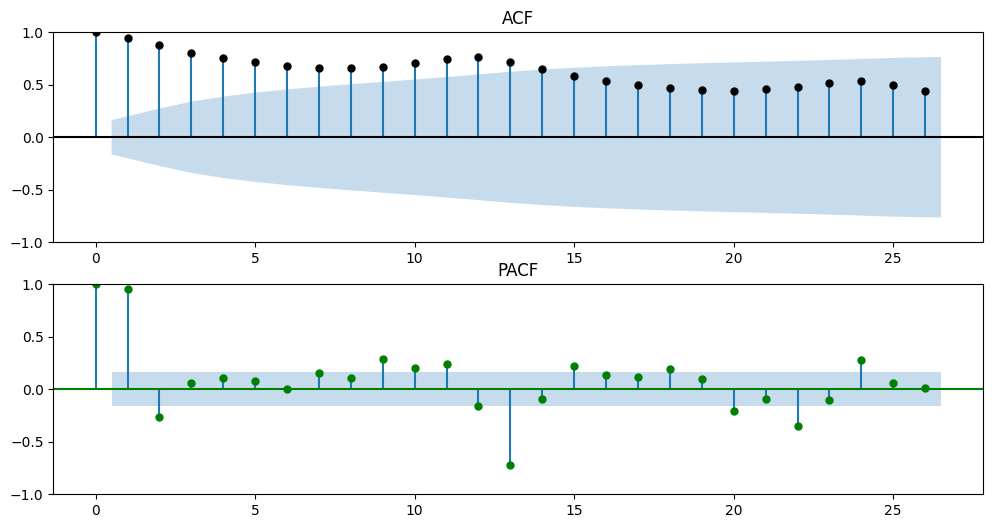

In [21]:
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f.plot_acf(lags=26,ax=axs[0],title='ACF',color='black')
f.plot_pacf(lags=26,ax=axs[1],title='PACF',color='green')
plt.show()

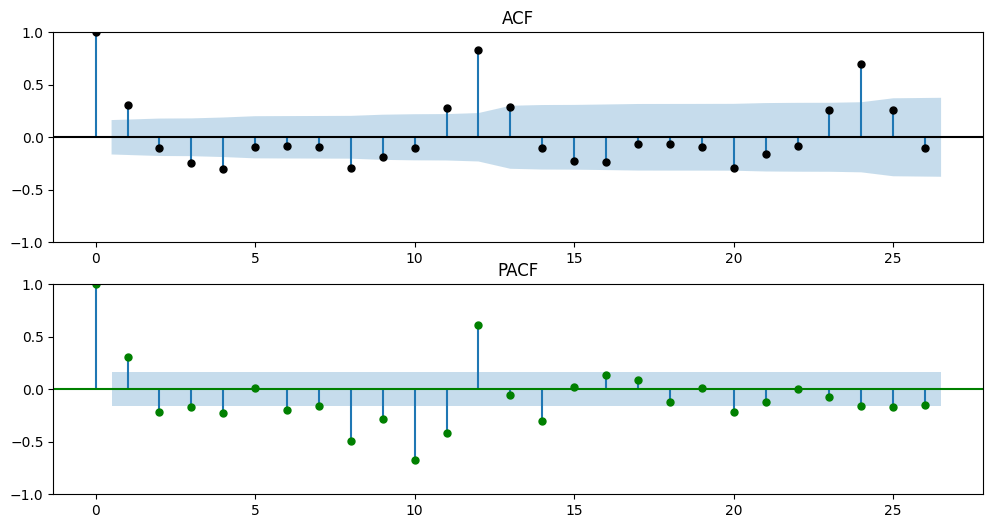

In [22]:
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f.plot_acf(diffy=True,ax=axs[0],title='ACF',lags=26,color='black')
f.plot_pacf(diffy=True,ax=axs[1],title='PACF',lags=26,color='green')
plt.show()

Transformations used to make the data stationary:

* DiffTransform(m) - takes differences (or seasonal differences) in the y attribute.
* DetrendTransform() - change in the mean over time.
* LogTransform()
* ScaleTransform() - change to a normal distribution N(0,1)
* MinMaxTransform() - change to a (0,1) distribution

Detrending removes overall upward trend so that resulting data just represents cyclical trend.

Reveting back the data can be done with:
* LogRevert()
* ScaleRevert()
* MinMaxRevert()
* DiffRevert(m)
* DetrendRevert()

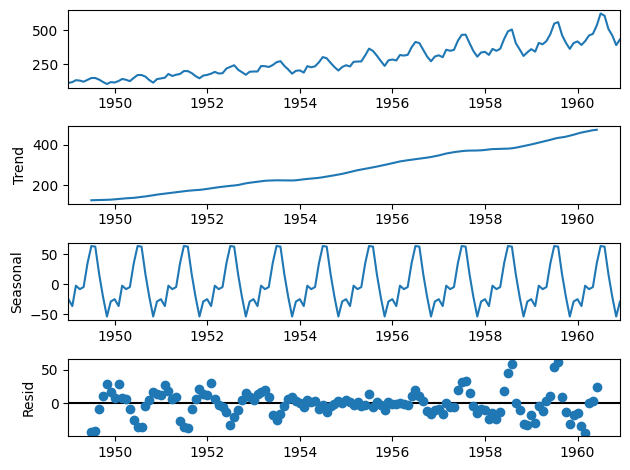

In [23]:
f.seasonal_decompose().plot()
plt.show()

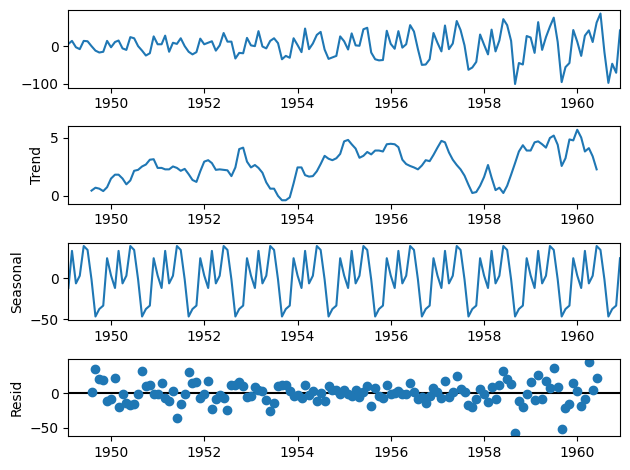

In [24]:
f.seasonal_decompose(diffy=True).plot()
plt.show();

In [25]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat)
print(pval)

0.8153688792060498
0.991880243437641


Check the trend for non-stationary and use the Augmented Dickey-Fuller test to give statistical justification to back up. Since the p-value is not less than 0.05, we must assume the series is non-stationary.

### LSTM Forecasting

To model anything in scalecast, we need to complete the following three basic steps:

1. Specify a test length — The test length is a discrete number of the last observations in the full time series. You can pass a percentage or a discrete number to the set_test_length function. In more recent scalecast versions, testing can be skipped by setting a test length of 0.
2. Generate future dates — The number of dates you generate in this step will determine how long all models will be forecast out.
3. Choose an estimator — we will be using the “lstm” estimator.

In [26]:
f.set_test_length(df_test.shape[0])         # 1. 12 observations to test the results
f.generate_future_dates(df_test.shape[0])   # 2. 12 future points to forecast
f.set_estimator('lstm')                     # 3. LSTM neural network

Now, to call an LSTM forecast. By default, this model will be run with a single input layer of 8 size, Adam optimizer, tanh activation, a single lagged dependent-variable value to train with, a learning rate of 0.001, and no dropout. All data is scaled going into the model with a min-max scaler and un-scaled coming out. Anything you can pass to the fit() method in TensorFlow, you can also pass to the scalecast manual_forecast() method.

In [27]:
f.add_seasonal_regressors(
    'month',
    'quarter',
    raw=False,
    sincos=True,
)

In [28]:
#f.set_estimator('xgboost')
#f.cross_validate() # tunes hyperparam values
#f.auto_forecast() # forecasts with the best params
f

Forecaster(
    DateStartActuals=1949-01-01T00:00:00.000000000
    DateEndActuals=1960-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=48
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos']
    TestLength=48
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=lstm
    GridsFile=Grids
)

1/1 [==============================] - 0s 306ms/step


3/3 [==============================] - 0s 3ms/step


<Axes: xlabel='Date', ylabel='Values'>

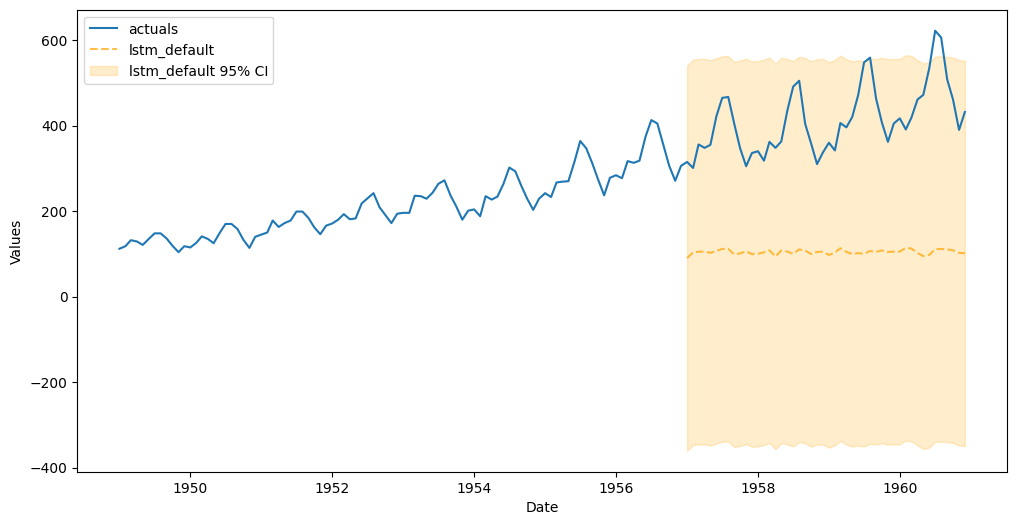

In [29]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

The Smape loss value for lstm_default model is 1.162373
The RMSE loss value for lstm_default model is 317.253034


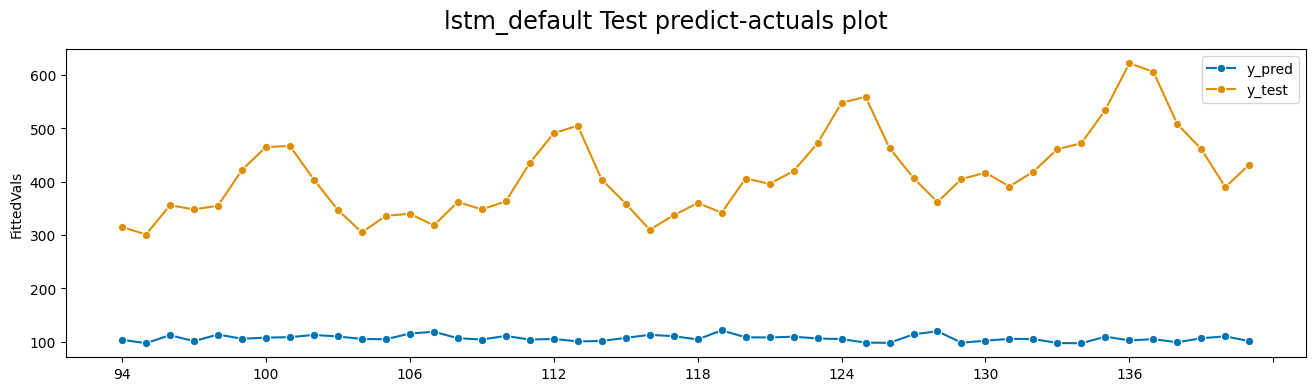

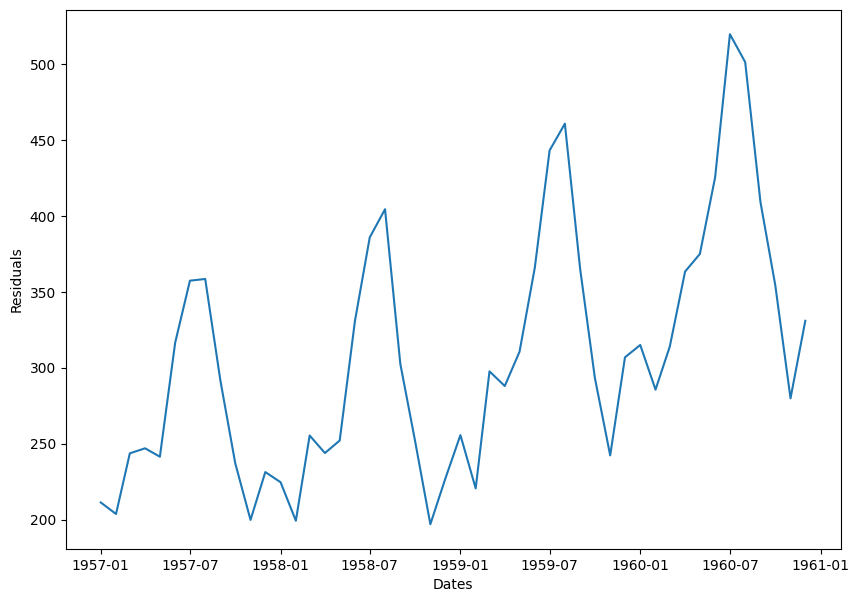

In [30]:
a = f.export_fitted_vals('lstm_default')
forecst(a, 'lstm_default')

In [31]:
print(df_train.ds.min(),df_train.ds.max())
print(df_test.ds.min(),df_test.ds.max())
print(df_train.shape,df_test.shape,df.shape)

1949-01-01 00:00:00 1956-12-01 00:00:00
1957-01-01 00:00:00 1960-12-01 00:00:00
(96, 6) (48, 6) (144, 6)


Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.4130 - val_loss: 0.5185
Epoch 2/5
1/1 [==============================] - 0s 38ms/step - loss: 0.4116 - val_loss: 0.5171
Epoch 3/5
1/1 [==============================] - 0s 34ms/step - loss: 0.4103 - val_loss: 0.5156
Epoch 4/5
1/1 [==============================] - 0s 32ms/step - loss: 0.4090 - val_loss: 0.5142
Epoch 5/5
1/1 [==============================] - 0s 304ms/step
Epoch 1/5
2/2 [==============================] - 2s 378ms/step - loss: 0.3500 - val_loss: 0.5536
Epoch 2/5
2/2 [==============================] - 0s 36ms/step - loss: 0.3470 - val_loss: 0.5500
Epoch 3/5
2/2 [==============================] - 0s 29ms/step - loss: 0.3440 - val_loss: 0.5464
Epoch 4/5
2/2 [==============================] - 0s 29ms/step - loss: 0.3409 - val_loss: 0.5427
Epoch 5/5
3/3 [==============================] - 0s 3ms/step


<Axes: xlabel='Date', ylabel='Values'>

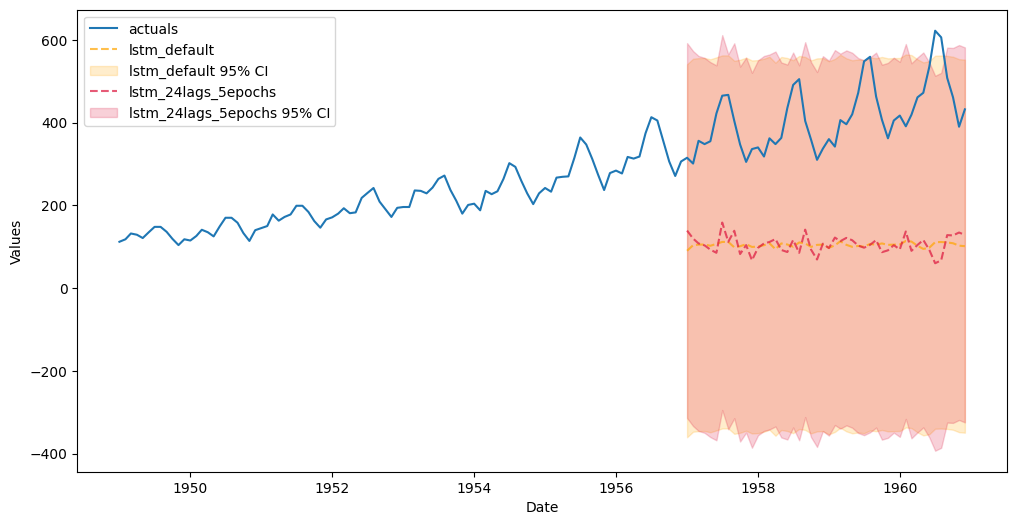

In [32]:
f.manual_forecast(
    call_me='lstm_24lags_5epochs',
    lags=24,
    epochs=5,
    validation_split=.2,
    shuffle=True,
)
f.plot_test_set(ci=True)

The Smape loss value for lstm_24lags_5epochs model is 1.130634
The RMSE loss value for lstm_24lags_5epochs model is 310.513237


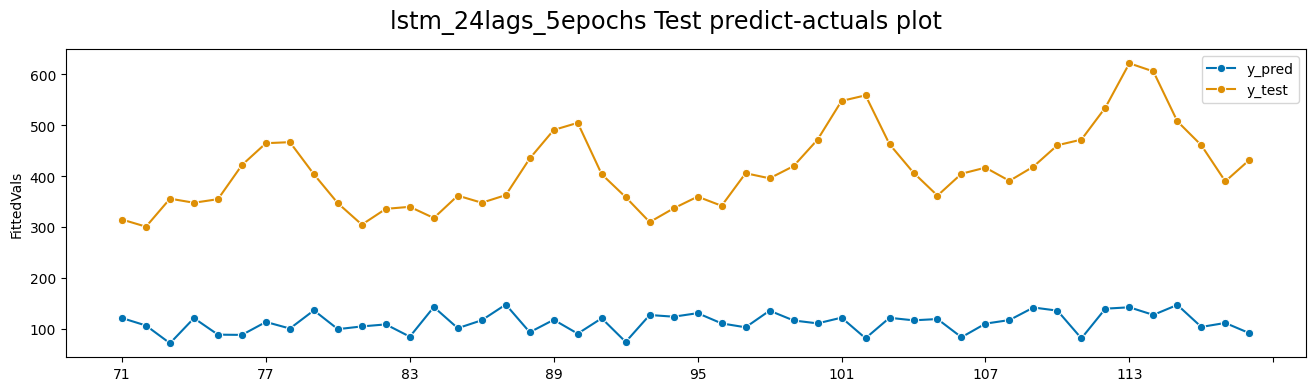

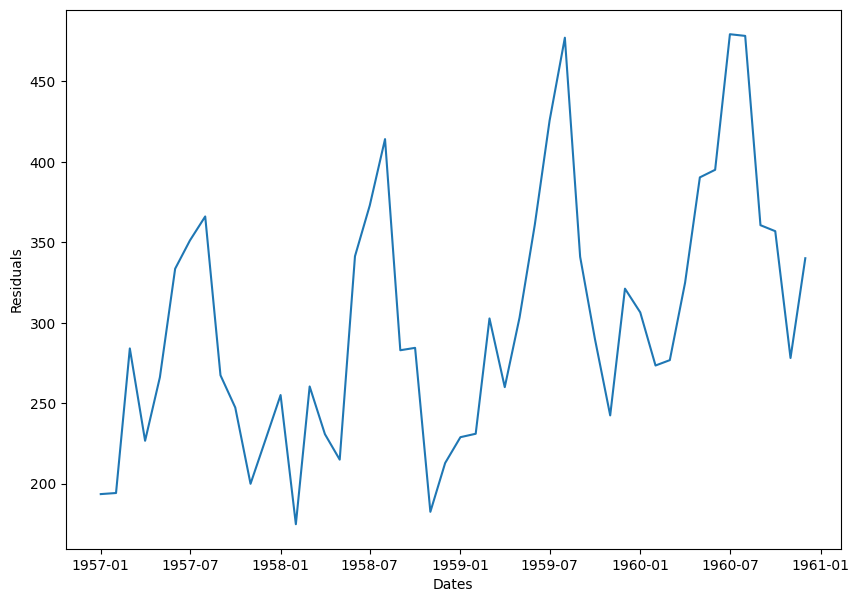

In [33]:
a = f.export_fitted_vals('lstm_24lags_5epochs')
forecst(a, 'lstm_24lags_5epochs')

In [34]:
f

Forecaster(
    DateStartActuals=1949-01-01T00:00:00.000000000
    DateEndActuals=1960-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=48
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24']
    TestLength=48
    ValidationMetric=rmse
    ForecastsEvaluated=['lstm_default', 'lstm_24lags_5epochs']
    CILevel=0.95
    CurrentEstimator=lstm
    GridsFile=Grids
)

Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.4141 - val_loss: 0.5195
Epoch 2/25
1/1 [==============================] - 0s 44ms/step - loss: 0.4118 - val_loss: 0.5169
Epoch 3/25
1/1 [==============================] - 0s 44ms/step - loss: 0.4096 - val_loss: 0.5144
Epoch 4/25
1/1 [==============================] - 0s 45ms/step - loss: 0.4074 - val_loss: 0.5119
Epoch 5/25
1/1 [==============================] - 0s 56ms/step - loss: 0.4052 - val_loss: 0.5093
Epoch 6/25
1/1 [==============================] - 0s 48ms/step - loss: 0.4029 - val_loss: 0.5065
Epoch 7/25
1/1 [==============================] - 0s 48ms/step - loss: 0.4005 - val_loss: 0.5036
Epoch 8/25
1/1 [==============================] - 0s 44ms/step - loss: 0.3980 - val_loss: 0.5005
Epoch 9/25
1/1 [==============================] - 0s 46ms/step - loss: 0.3953 - val_loss: 0.4971
Epoch 10/25
1/1 [==============================] - 0s 46ms/step - loss: 0.3923 - val_loss: 0.4934
Epoch 11/25
1/1 [==============

1/1 [==============================] - 1s 784ms/step
Epoch 1/25
2/2 [==============================] - 5s 856ms/step - loss: 0.3491 - val_loss: 0.5509
Epoch 2/25
2/2 [==============================] - 0s 41ms/step - loss: 0.3445 - val_loss: 0.5455
Epoch 3/25
2/2 [==============================] - 0s 43ms/step - loss: 0.3396 - val_loss: 0.5395
Epoch 4/25
2/2 [==============================] - 0s 47ms/step - loss: 0.3340 - val_loss: 0.5322
Epoch 5/25
2/2 [==============================] - 0s 41ms/step - loss: 0.3272 - val_loss: 0.5231
Epoch 6/25
2/2 [==============================] - 0s 46ms/step - loss: 0.3187 - val_loss: 0.5115
Epoch 7/25
2/2 [==============================] - 0s 45ms/step - loss: 0.3079 - val_loss: 0.4964
Epoch 8/25
2/2 [==============================] - 0s 40ms/step - loss: 0.2939 - val_loss: 0.4764
Epoch 9/25
2/2 [==============================] - 0s 40ms/step - loss: 0.2760 - val_loss: 0.4496
Epoch 10/25
2/2 [==============================] - 0s 41ms/step - loss: 0

3/3 [==============================] - 0s 6ms/step


<Axes: xlabel='Date', ylabel='Values'>

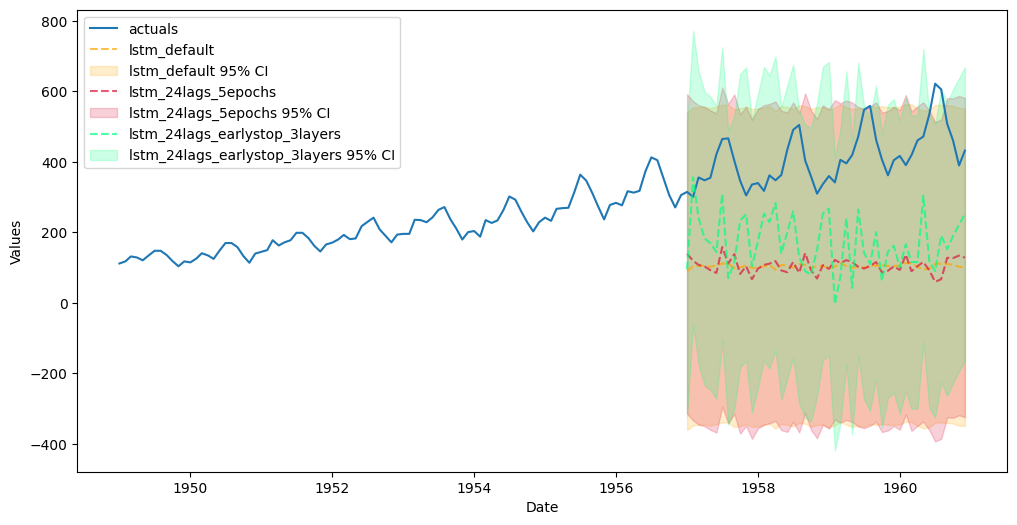

In [35]:
f.manual_forecast(
    call_me='lstm_24lags_earlystop_3layers',
    lags=24,
    epochs=25,
    validation_split=.2,
    shuffle=True,
    callbacks=EarlyStopping(
        monitor='val_loss',
        patience=5,
    ),
    lstm_layer_sizes=(16,16,16),
    dropout=(0,0,0),
)

f.plot_test_set(ci=True)

The Smape loss value for lstm_24lags_earlystop_3layers model is 0.354981
The RMSE loss value for lstm_24lags_earlystop_3layers model is 151.756077


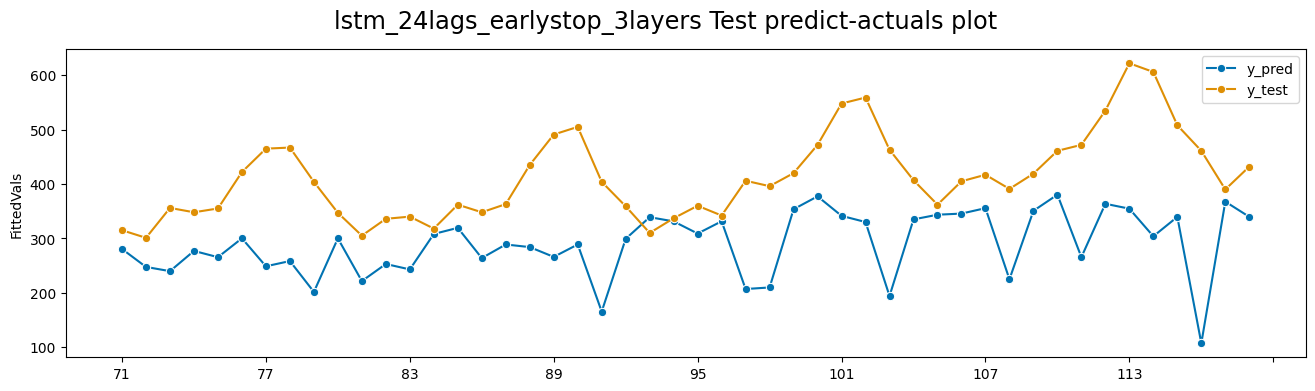

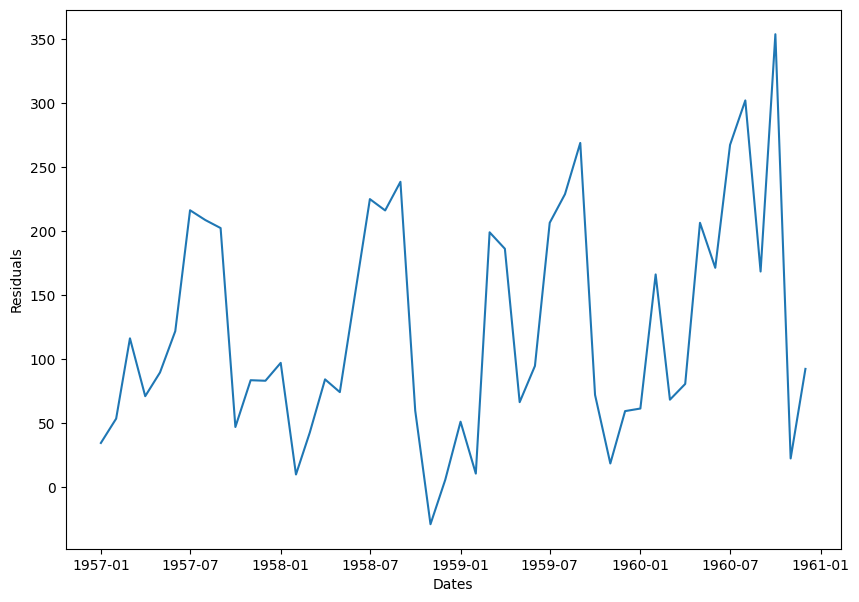

In [36]:
a = f.export_fitted_vals('lstm_24lags_earlystop_3layers')
forecst(a, 'lstm_24lags_earlystop_3layers')

Epoch 1/15
1/1 [==============================] - 7s 7s/step - loss: 0.4712 - val_loss: 0.5219
Epoch 2/15
1/1 [==============================] - 0s 74ms/step - loss: 0.4667 - val_loss: 0.5157
Epoch 3/15
1/1 [==============================] - 0s 75ms/step - loss: 0.4610 - val_loss: 0.5061
Epoch 4/15
1/1 [==============================] - 0s 77ms/step - loss: 0.4523 - val_loss: 0.4907
Epoch 5/15
1/1 [==============================] - 0s 75ms/step - loss: 0.4384 - val_loss: 0.4650
Epoch 6/15
1/1 [==============================] - 0s 82ms/step - loss: 0.4151 - val_loss: 0.4217
Epoch 7/15
1/1 [==============================] - 0s 76ms/step - loss: 0.3766 - val_loss: 0.3680
Epoch 8/15
1/1 [==============================] - 0s 76ms/step - loss: 0.3288 - val_loss: 0.3501
Epoch 9/15
1/1 [==============================] - 0s 83ms/step - loss: 0.3125 - val_loss: 0.3366
Epoch 10/15
1/1 [==============================] - 0s 73ms/step - loss: 0.3072 - val_loss: 0.3041
Epoch 11/15
1/1 [==============

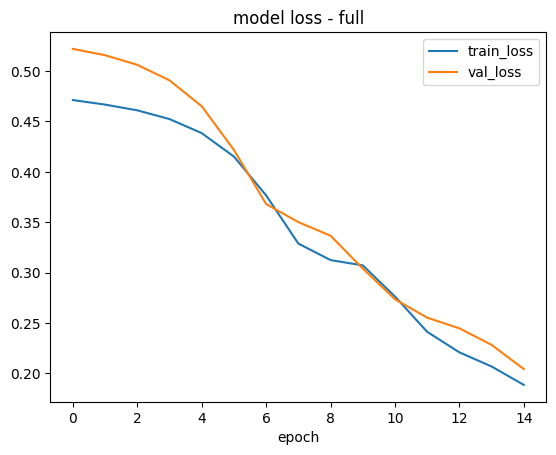

Epoch 1/15
2/2 [==============================] - 8s 2s/step - loss: 0.3894 - val_loss: 0.5495
Epoch 2/15
2/2 [==============================] - 0s 78ms/step - loss: 0.3759 - val_loss: 0.5169
Epoch 3/15
2/2 [==============================] - 0s 86ms/step - loss: 0.3458 - val_loss: 0.4285
Epoch 4/15
2/2 [==============================] - 0s 96ms/step - loss: 0.2739 - val_loss: 0.3316
Epoch 5/15
2/2 [==============================] - 0s 98ms/step - loss: 0.2557 - val_loss: 0.2836
Epoch 6/15
2/2 [==============================] - 0s 82ms/step - loss: 0.2111 - val_loss: 0.2667
Epoch 7/15
2/2 [==============================] - 0s 78ms/step - loss: 0.1767 - val_loss: 0.2562
Epoch 8/15
2/2 [==============================] - 0s 87ms/step - loss: 0.1548 - val_loss: 0.2038
Epoch 9/15
2/2 [==============================] - 0s 80ms/step - loss: 0.1295 - val_loss: 0.1776
Epoch 10/15
2/2 [==============================] - 0s 82ms/step - loss: 0.1220 - val_loss: 0.1776
Epoch 11/15
2/2 [==============

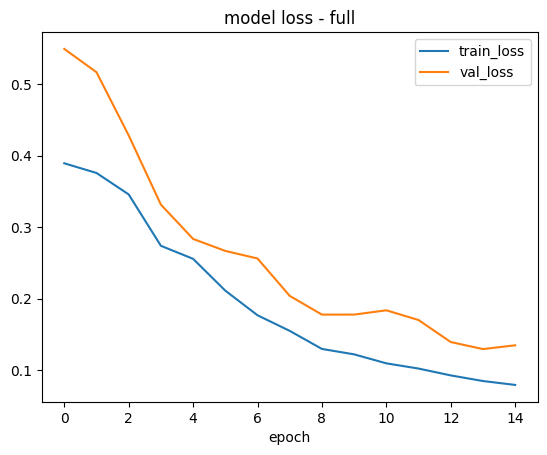

<Axes: xlabel='Date', ylabel='Values'>

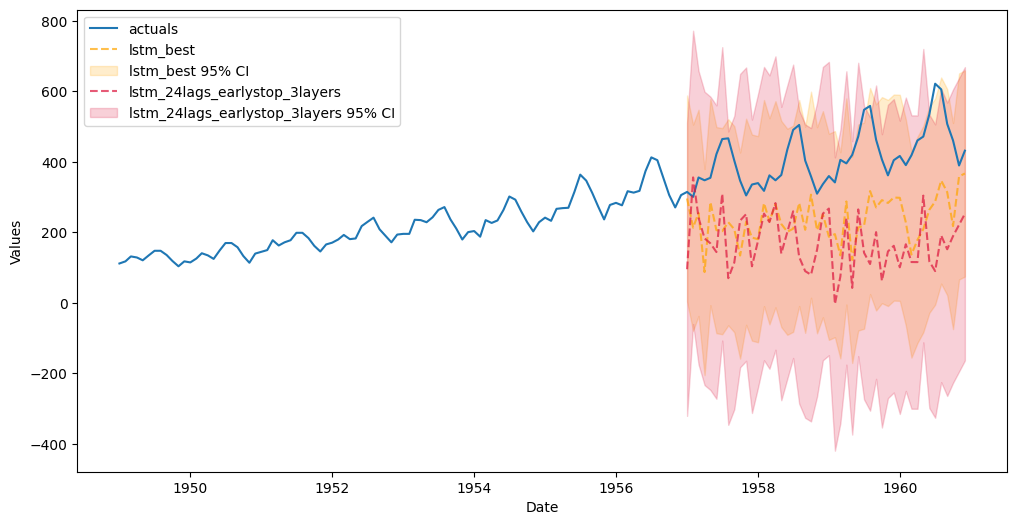

In [37]:
f.manual_forecast(
    call_me='lstm_best',
    lags=36,
    batch_size=32,
    epochs=15,
    validation_split=.2,
    shuffle=True,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(72,)*4,
    dropout=(0,)*4,
    plot_loss=True
)
#f.plot_test_set(ci=True)
f.plot_test_set(order_by='TestSetRMSE',models='top_2',ci=True)

The Smape loss value for lstm_best model is 0.197293
The RMSE loss value for lstm_best model is 97.239120


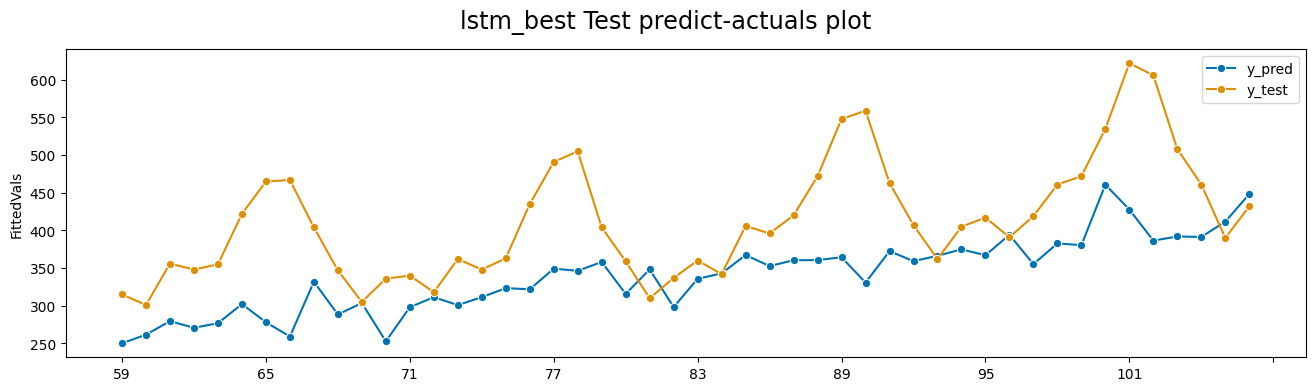

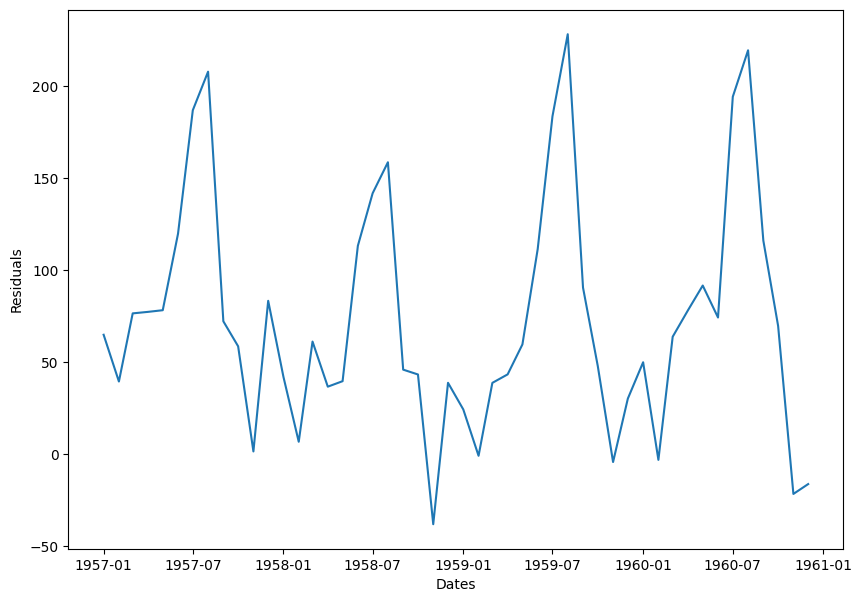

In [38]:
a = f.export_fitted_vals('lstm_best')
forecst(a, 'lstm_best')

<Axes: xlabel='Date', ylabel='Values'>

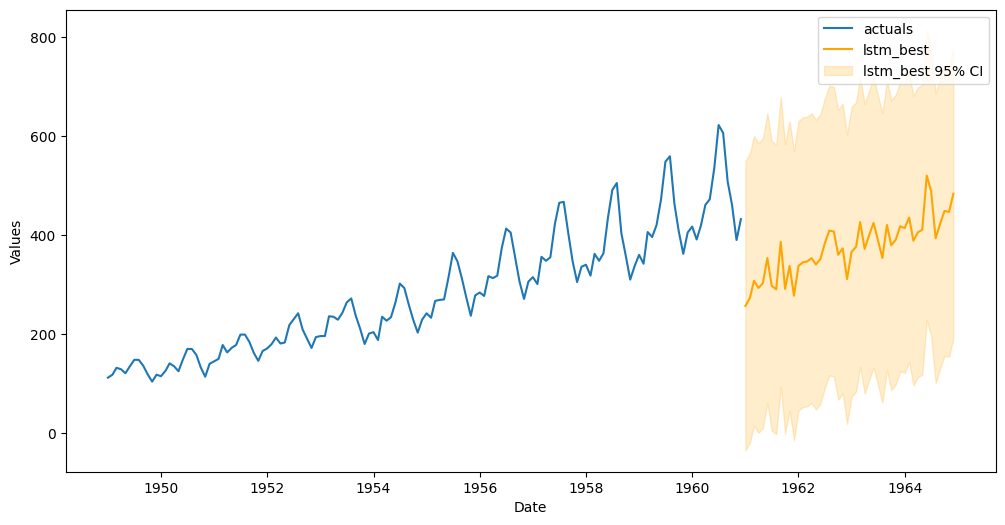

In [39]:
f.plot(ci=True, models = ['lstm_best'])

Epoch 1/300
1/1 [==============================] - 25s 25s/step - loss: 0.4712 - val_loss: 0.5217
Epoch 2/300
1/1 [==============================] - 0s 277ms/step - loss: 0.4660 - val_loss: 0.5120
Epoch 3/300
1/1 [==============================] - 0s 246ms/step - loss: 0.4564 - val_loss: 0.4908
Epoch 4/300
1/1 [==============================] - 0s 262ms/step - loss: 0.4351 - val_loss: 0.4405
Epoch 5/300
1/1 [==============================] - 0s 253ms/step - loss: 0.3848 - val_loss: 0.3446
Epoch 6/300
1/1 [==============================] - 0s 274ms/step - loss: 0.2862 - val_loss: 0.2900
Epoch 7/300
1/1 [==============================] - 0s 247ms/step - loss: 0.2634 - val_loss: 0.2596
Epoch 8/300
1/1 [==============================] - 0s 250ms/step - loss: 0.2457 - val_loss: 0.2149
Epoch 9/300
1/1 [==============================] - 0s 266ms/step - loss: 0.1954 - val_loss: 0.1888
Epoch 10/300
1/1 [==============================] - 0s 263ms/step - loss: 0.1533 - val_loss: 0.1820
Epoch 11/3

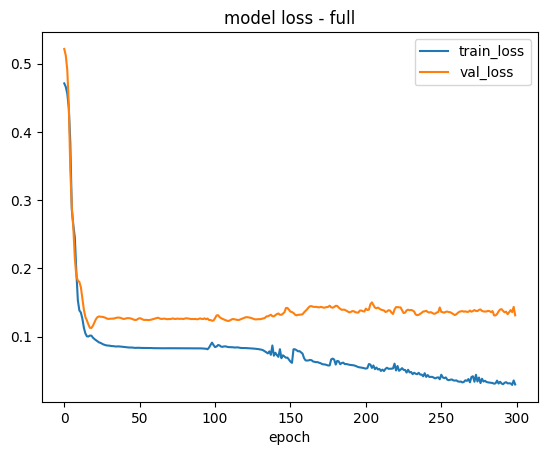

Epoch 1/300
3/3 [==============================] - 22s 2s/step - loss: 0.3853 - val_loss: 0.5354
Epoch 2/300
3/3 [==============================] - 1s 338ms/step - loss: 0.3122 - val_loss: 0.3209
Epoch 3/300
3/3 [==============================] - 1s 376ms/step - loss: 0.2351 - val_loss: 0.3301
Epoch 4/300
3/3 [==============================] - 1s 270ms/step - loss: 0.1765 - val_loss: 0.2496
Epoch 5/300
3/3 [==============================] - 1s 262ms/step - loss: 0.1432 - val_loss: 0.1757
Epoch 6/300
3/3 [==============================] - 1s 255ms/step - loss: 0.1160 - val_loss: 0.2132
Epoch 7/300
3/3 [==============================] - 1s 256ms/step - loss: 0.1069 - val_loss: 0.1934
Epoch 8/300
3/3 [==============================] - 1s 262ms/step - loss: 0.1049 - val_loss: 0.1729
Epoch 9/300
3/3 [==============================] - 1s 265ms/step - loss: 0.0994 - val_loss: 0.1968
Epoch 10/300
3/3 [==============================] - 1s 260ms/step - loss: 0.0959 - val_loss: 0.1897
Epoch 11/30

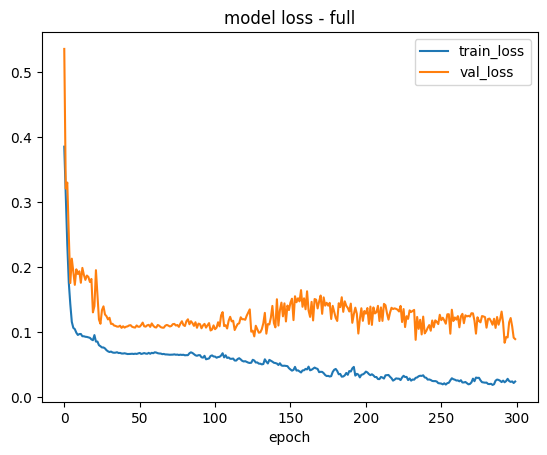

In [40]:
f.manual_forecast(
    call_me='lstm_best1',
    lags=36,
    batch_size=16,
    epochs= 300, #30,
    validation_split=.2,
    shuffle=True,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(100,)*15,
    dropout=(0,)*15,
    plot_loss=True,
)

<Axes: xlabel='Date', ylabel='Values'>

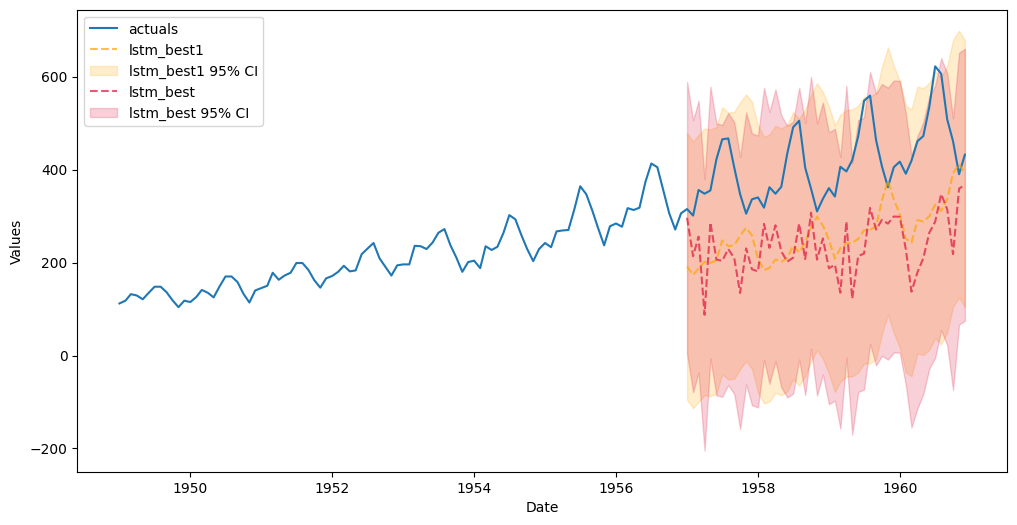

In [41]:
f.plot_test_set(order_by='TestSetRMSE',models='top_2',ci=True)

The Smape loss value for lstm_best1 model is 0.177691
The RMSE loss value for lstm_best1 model is 96.626723


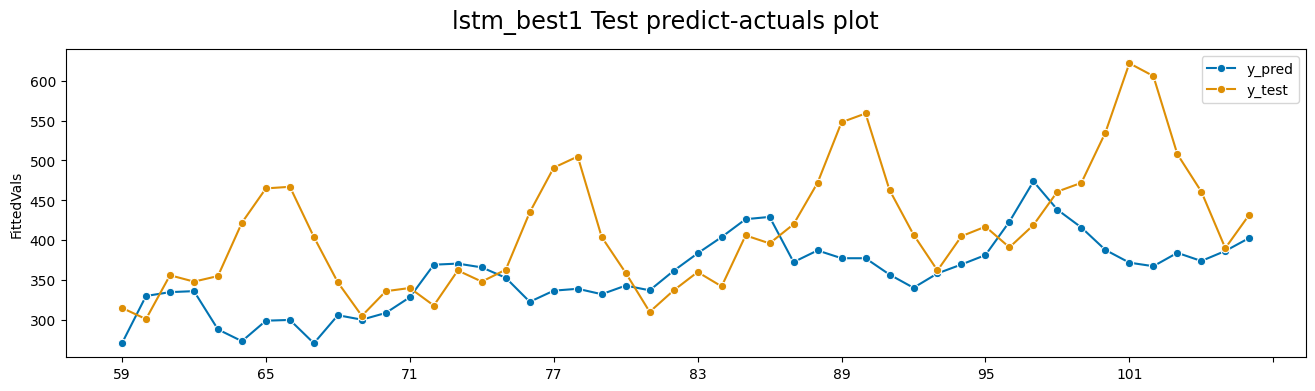

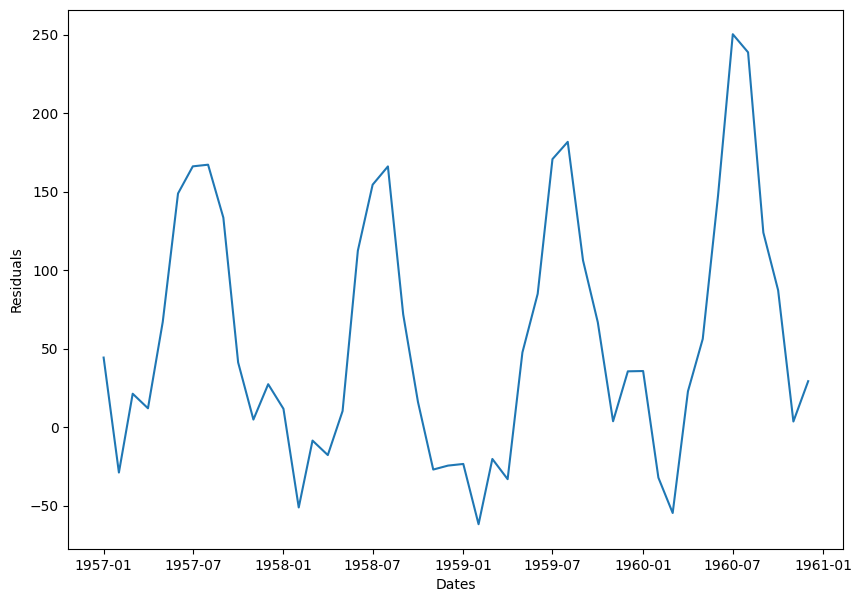

In [42]:
a = f.export_fitted_vals('lstm_best1')
forecst(a, 'lstm_best1')

<Axes: xlabel='Date', ylabel='Values'>

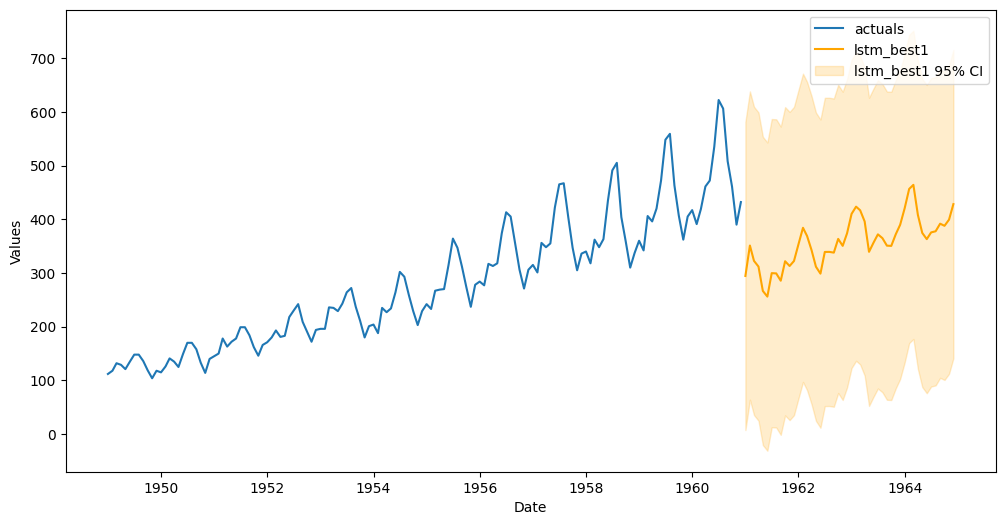

In [43]:
f.plot(ci=True, models = ['lstm_best1'])

### Stationary series

In [47]:
f = Forecaster(y = df['y'],
               current_dates = df['ds'],
               cis = True)
f

Forecaster(
    DateStartActuals=1949-01-01T00:00:00.000000000
    DateEndActuals=1960-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [48]:
transformer = SeriesTransformer(f)

In [49]:
f_log = transformer.LogTransform()
f_log = transformer.DetrendTransform()

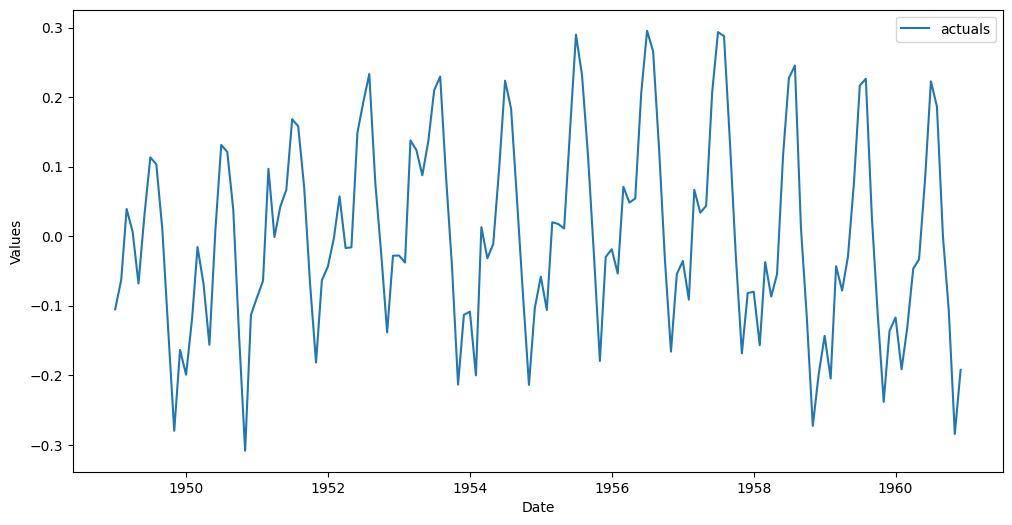

In [50]:
f_log.plot()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


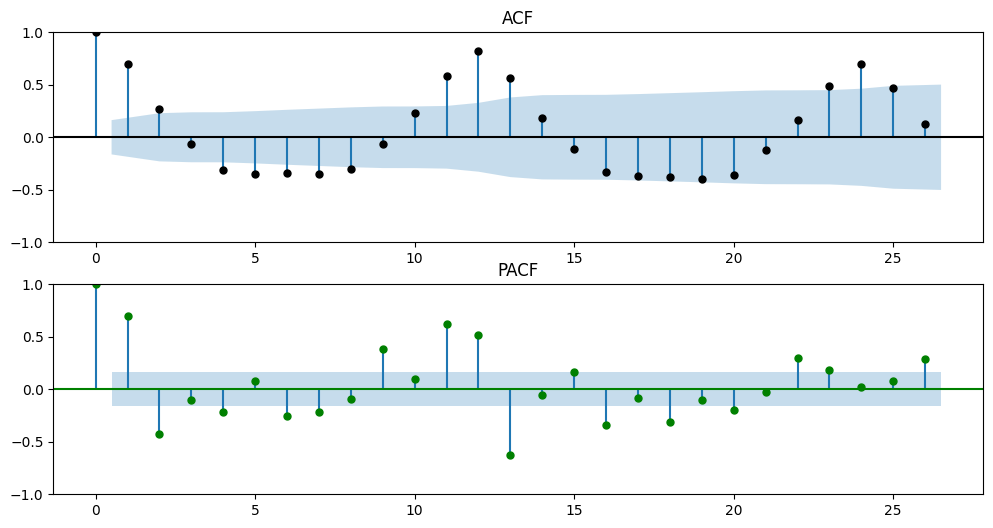

In [51]:
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f_log.plot_acf(lags=26,ax=axs[0],title='ACF',color='black')
f_log.plot_pacf(lags=26,ax=axs[1],title='PACF',color='green')
plt.show()



In [52]:
stat, pval, _, _, _, _ = f_log.adf_test(full_res=True)
print(stat)
print(pval)

-2.2606619896316635
0.18496919097991643


In [53]:
f_trans = transformer.DiffTransform(1)
f_trans = transformer.DiffTransform(1)    # second differencing
f_trans = transformer.DetrendTransform()

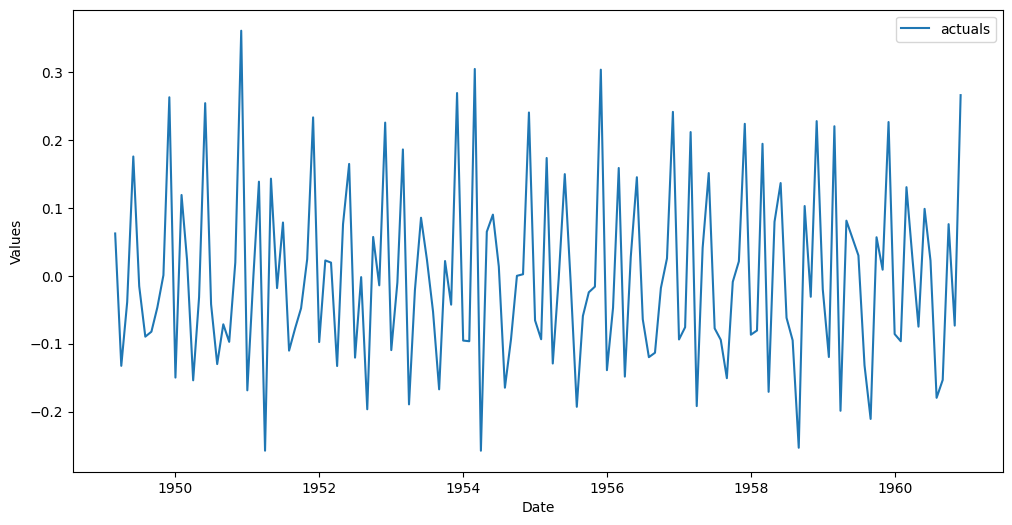

In [54]:
f_trans.plot()
plt.show()

In [55]:
stat, pval, _, _, _, _ = f_trans.adf_test(full_res=True)
print(stat)
print(pval)

-3.672630742059883
0.0045150185187391775


#### ARIMA model

In [ ]:
f = Forecaster(y = df['y'],
               current_dates = df['ds'],
               cis = True)

f.set_test_length(df_test.shape[0])         # 1. 12 observations to test the results
f.generate_future_dates(df_test.shape[0])   # 2. 12 future points to forecast
f.set_estimator('arima')                     # 3. LSTM neural network

In [ ]:
auto_arima(
    f,
    m=12,
    trace=True,
    stepwise=True,
    call_me='arima_3',
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=1.75 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.91 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=4.14 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.79 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=1.34 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.14 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.32 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.85 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.83 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=1.67 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.09 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.09 sec
 ARIMA(3,1,1)(0,1,0

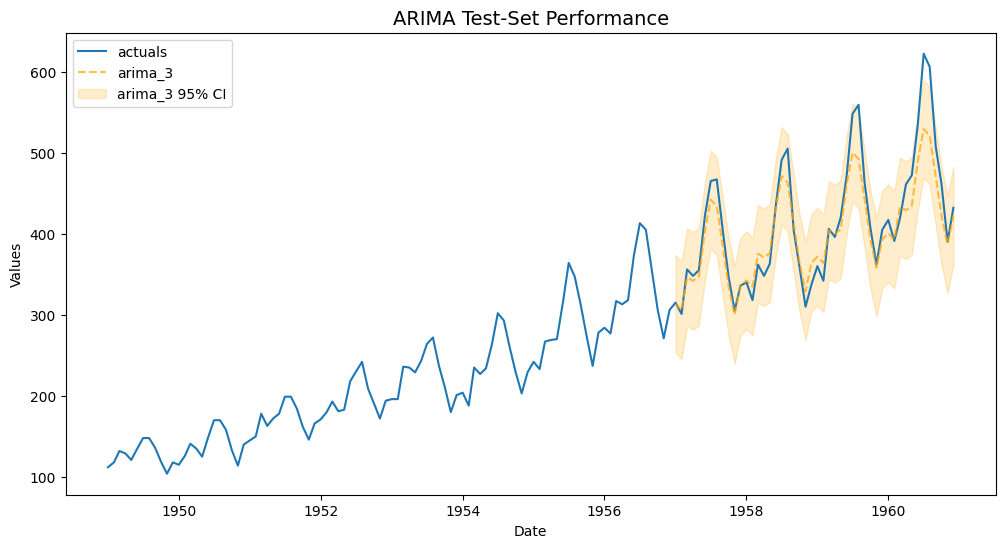

In [ ]:
f.plot_test_set(ci=True,models='arima_3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

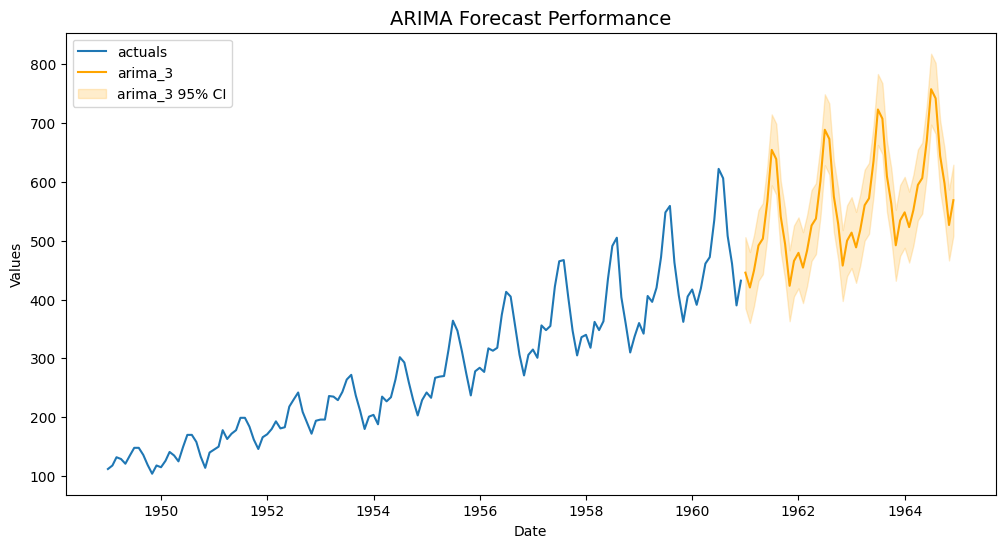

In [ ]:
f.plot(ci=True,models='arima_3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

The Smape loss value for arima_3 model is 0.026449
The RMSE loss value for arima_3 model is 13.949458


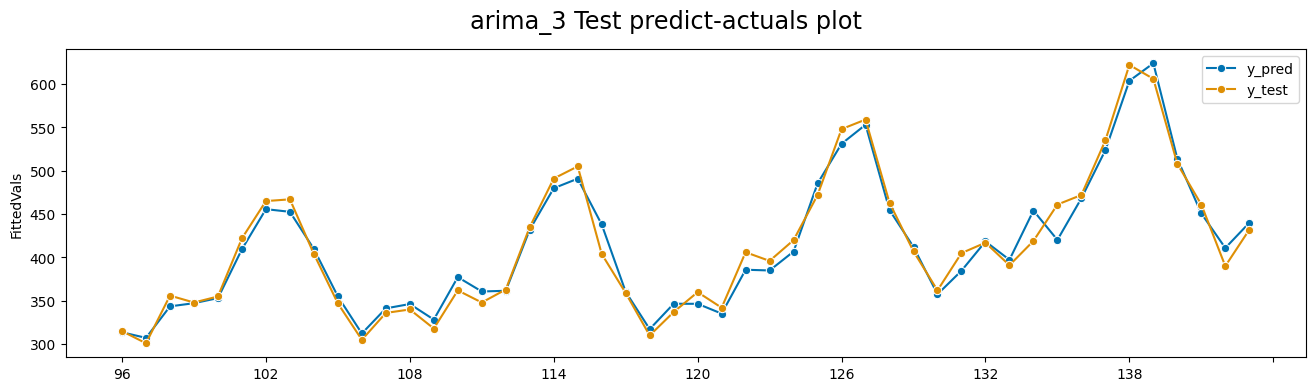

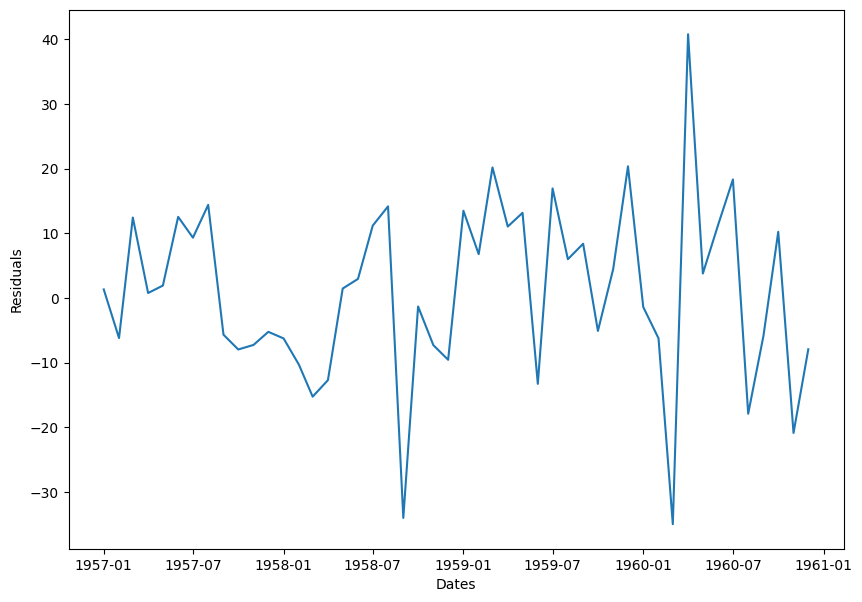

In [ ]:
a = f.export_fitted_vals('arima_3')
forecst(a, 'arima_3')

### MLR Forecasting and Model Benchmarking

To switch from an LSTM to an MLR model in scalecast, we need to follow these steps:

1. Choose the MLR estimator — just like how we previously chose the LSTM estimator.
2. Add regressors to the model —in LSTM, we only used the series’ own history and let the model parameterize itself. With MLR, we can still use the series’ own history, but we can also add information about which month, quarter, or year any given observation falls into to capture seasonality and a time trend (among other options). We could even ingest a dataframe of our own regressors (not shown here).
3. Difference non-stationary data — this is how we mitigate the results of the Augmented Dickey-Fuller test showing we had non-stationary data. We could have done this with LSTM as well, but we were hoping it was sophisticated enough to work without this step.

In [ ]:
transformer = SeriesTransformer(f)
f = transformer.DiffTransform()

f.add_ar_terms(24)
f.add_seasonal_regressors('month','quarter',dummy=True)
f.add_seasonal_regressors('year')
f.add_time_trend()

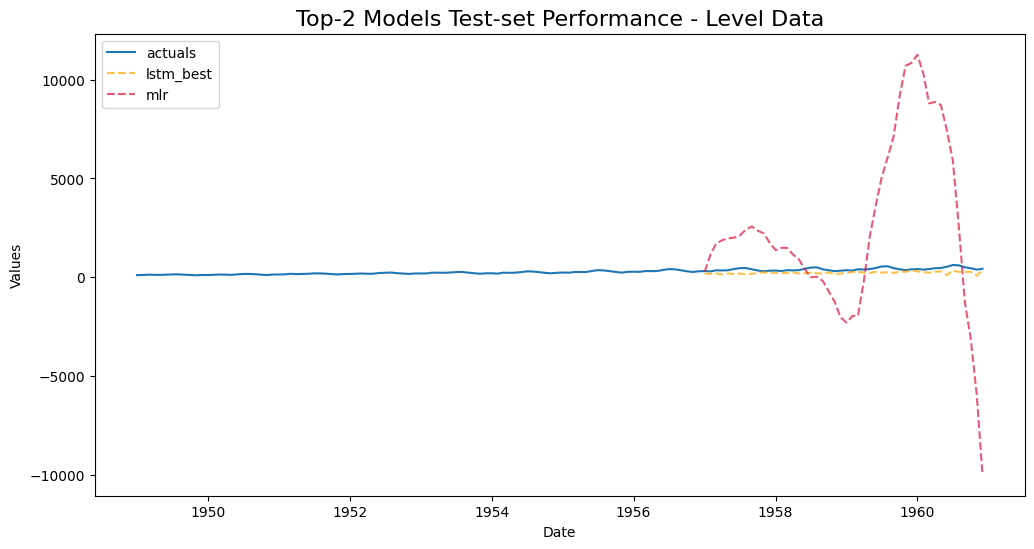

In [ ]:
f.set_estimator('all')
f.manual_forecast()

f = transformer.DiffRevert(
    exclude_models = [m for m in f.history if m != 'mlr']
) # exclude all lstm models from the revert

f.plot_test_set(order_by='TestSetMAPE',models=['lstm_best','all'])
plt.title('Top-2 Models Test-set Performance - Level Data',size=16)
plt.show()

<Axes: xlabel='Date', ylabel='Values'>

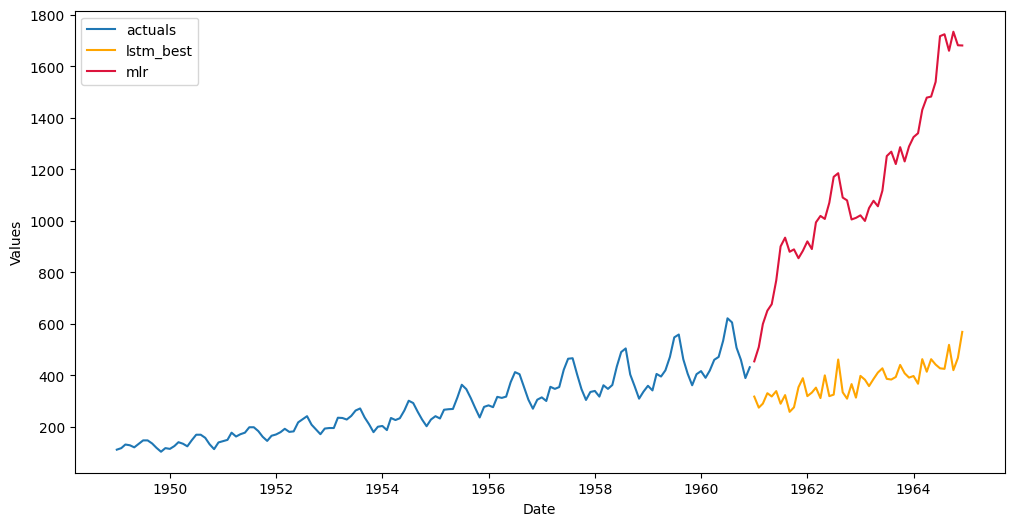

In [ ]:
f.plot(
    models=['mlr','lstm_best'],
    order_by='TestSetMAPE'
)

In [ ]:
f.export('model_summaries',determine_best_by='TestSetMAPE')[
    ['ModelNickname',
     'TestSetMAPE',
     'TestSetRMSE',
     'TestSetR2',
     'best_model']
]

,ModelNickname,TestSetMAPE,TestSetRMSE,TestSetR2,best_model
0,lstm_best,0.430119,200.728578,-5.677903,True
1,lstm_24lags_earlystop_3layers,0.583417,267.338312,-10.845247,False
2,lstm_default,0.737655,318.668470,-15.830612,False
3,lstm_24lags_5epochs,0.741283,322.175883,-16.203142,False
4,mlr,8.421295,4855.533772,-3906.470204,False


### Prophet models

In [ ]:
print(df_train.shape, df_test.shape)

(96, 6) (48, 6)


In [ ]:
cha_res = cap_floor(df_train, df_test, 'Prophet', initial = '900 days', period = '300 days',
                    horizon =  '144 days')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

###############
### Results ###
###############

res_dset = pd.DataFrame()

res_dset = res_data(cha_res,'smape','Prophet',res_dset)

res_dset = res_data(cha_res,'rmse','Prophet',res_dset)

res_dset

The best model is the Baseline model
The best model is the Baseline model


,Prophet Smape,Prophet Model,Prophet Rmse,Prophet Model
0,0.048071,Baseline,14.634741,Baseline
1,0.051014,Flexible,15.315652,Flexible
2,0.057601,Strict,16.194243,HRS
3,0.057706,HRS,16.461439,Strict
4,0.467099,Constructed,1087.495274,Constructed


In [ ]:
### Set up parameter grid ###

param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['multiplicative','additive'],
    'growth': ['linear','logistic'],
    'weekly_seasonality': [False],
    'yearly_seasonality': [True],
    'daily_seasonality': [False]
}

### Generate all combinations of parameters ###

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

prop_params = hyper(df_train, df_test, '900 days', '300 days', '144 days')

<ipython-input-8-e95ce57099fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dset['cap'] = max(int(max(train_dset.y) * 1.1),int(max(test_dset.y) * 1.1))
<ipython-input-8-e95ce57099fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dset['floor'] = 0
<ipython-input-8-e95ce57099fe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'seasonality_mode': 'additive', 'growth': 'linear', 'weekly_seasonality': False, 'yearly_seasonality': True, 'daily_seasonality': False}


In [ ]:
print('Prophet parameters ', prop_params)

Prophet parameters  {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'seasonality_mode': 'additive', 'growth': 'linear', 'weekly_seasonality': False, 'yearly_seasonality': True, 'daily_seasonality': False}


<ipython-input-9-1e26758bf9f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dset['cap'] = max(int(max(train_dset.y) * 1.1),int(max(test_dset.y) * 1.1))
<ipython-input-9-1e26758bf9f4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dset['floor'] = 0
<ipython-input-9-1e26758bf9f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

96 48


INFO:prophet:Making 7 forecasts with cutoffs between 1951-08-06 00:00:00 and 1956-07-10 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 24.


The Smape loss value for Prophet is 0.101862
The RMSE value is 48.23027545608427


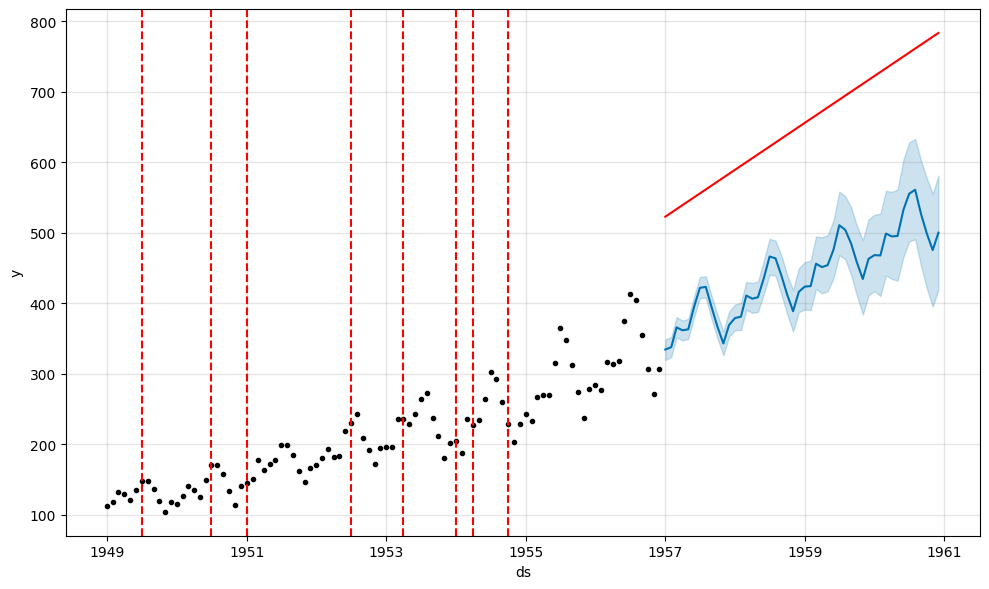

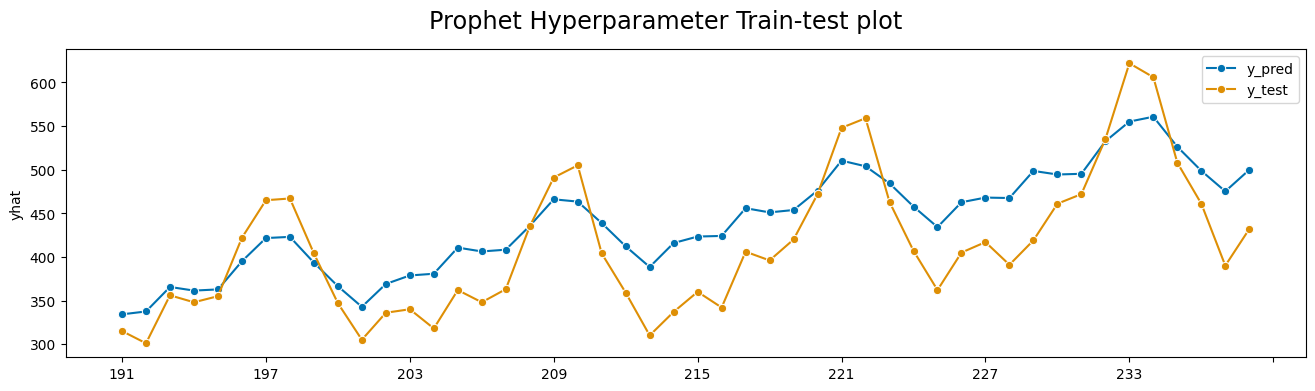

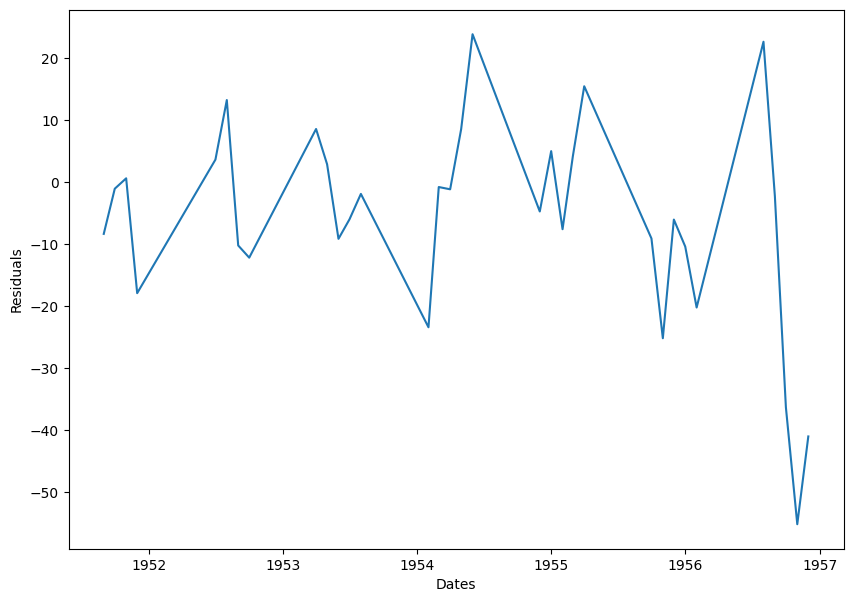

   horizon        mse       rmse        mae      mape     mdape     smape  \
0 144 days  315.62097  17.765725  12.682353  0.050268  0.036567  0.048727   

   coverage  
0  0.484848  


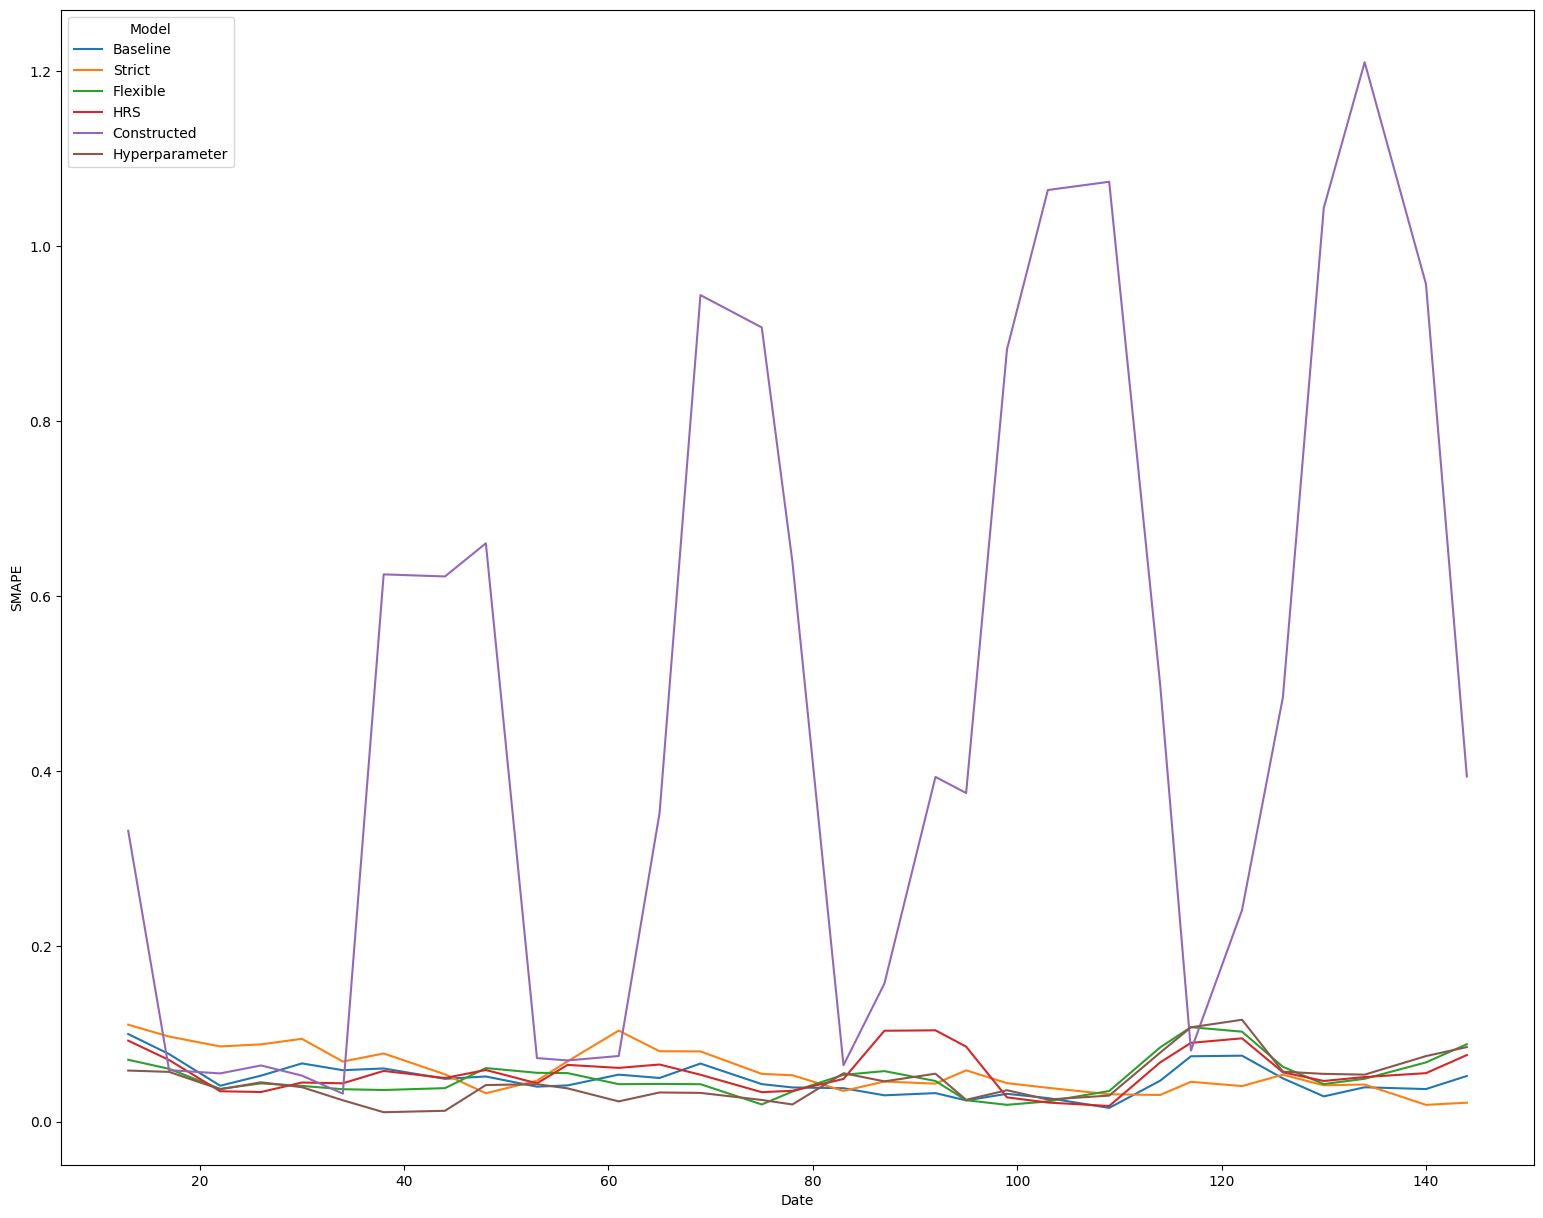

In [ ]:
prophet_all = all_mod(df_train, df_test, prop_params, cha_res, '900 days', '300 days', '144 days', 'Prophet')

In [ ]:
perf_vals(prophet_all, meas = 'smape')

The best model is the Hyperparameter model


,smape
Model,
Hyperparameter,0.046354
Baseline,0.048071
Flexible,0.051014
Strict,0.057601
HRS,0.057706
Constructed,0.467099
